<a href="https://colab.research.google.com/github/LucaAtOpit/Multimodal-Sentiment-Analysis/blob/main/Multimodal_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal-Sentiment-Analysis

This project aims to build a Multi-modal sentiment Analysis for the [Twitter Dataset for Sentiment Analysis](https://www.kaggle.com/datasets/dunyajasim/twitter-dataset-for-sentiment-analysis)

Quoting from the Dataset page in Kaggle:


> About Dataset

> This Twitter Dataset (MVSA with Sentiment Label Enrichment) is Based on Our Paper Titled "The Enrichment Of MVSA Twitter Data Via Caption-Generated Label Using Sentiment Analysis".

> If the datasets are useful for your research, please cite our work [1] and the work [2].

> The Eriched MVSA dataset:

> [1] D. J. Mohammed and H. J. Aleqabie, "The Enrichment Of MVSA Twitter Data Via Caption-Generated Label Using Sentiment Analysis," 2022 Iraqi International Conference on Communication and Information Technologies (IICCIT), Basrah, Iraq, 2022, pp. 322-327, doi: 10.1109/IICCIT55816.2022.10010435.

> The Original Dataset (Which We Developed on):

> [2] T. Niu, S. A. Zhu, L. Pang and A. El Saddik, Sentiment Analysis on Multi-view Social Data, MultiMedia Modeling (MMM), pp: 15-27, Miami, 2016.

## Environment

In order to start the project the first step is to download the `requirements.txt` filein the notebook environment, this step will ensure that the notebook can be run. Once ready in this section four actions are performed:
*   Install and update the required packages.
*   Import the required packages.
*   Specify the url where the dataset is available and where it's going to be downloaded.
*   Check the availablity of the GPU for faster model training.

---

**Note**: While installing the torchvision model an incompatibility error may appear in Google Colab, this error doesn't affect the code execution, and can be ignored.

In [ ]:
%pip install -q --no-input -r requirements.txt

In [ ]:
# Import Packages
import requests
import zipfile
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from PIL import Image
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from datasets import Dataset as HFDataset, Image
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    TrainingArguments,
    MobileNetV2ImageProcessor,
    MobileNetV2ForImageClassification,
    Trainer
)
import evaluate
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torch.optim as optim
import copy
import joblib

In [ ]:
# Define the URL and output file name
url = "https://www.kaggle.com/api/v1/datasets/download/dunyajasim/twitter-dataset-for-sentiment-analysis"
output_file = "twitter-dataset-for-sentiment-analysis.zip"

In [ ]:
# Check for CUDA and set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Functions and Classes

During the code execution we're going to use several functions and classes, this section details them including docstrings and comments on usage. The rationale behind the code in this section will become apparent when they're going to be used. In a later section, while saving the model for future use, we're also going to pickle the **MultimodalPreprocessor** and **MultimodalDataset** classes for ease of use.

In [ ]:
def download_file(url, output_file):
    """Downloads a file from a given URL and saves it to a specified location.

    Args:
        url (str): The URL of the file to download.
        output_file (str): The path and name of the file to save.

    Returns:
        None. Prints a message indicating success or failure.
    """
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(output_file, "wb") as file:
                for chunk in response.iter_content(chunk_size=1024):
                    file.write(chunk)
            print(f"File downloaded successfully: {output_file}")
        else:
            print(f"Failed to download file. HTTP Status Code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
def compute_metrics(eval_pred, metric_name, average='weighted'):
    """
    Computes and returns a dictionary of metrics (e.g., accuracy, F1 score)
    given the predictions and labels.

    Args:
        eval_pred (tuple): Predictions and labels from the evaluation set.
        metric_name (str): The name of the metric to compute (e.g., 'f1').
        average (str): How to average the F1 score for multi-class classification. Defaults to 'weighted'.

    Returns:
        dict: A dictionary containing the computed metric value.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Load the metric
    metric = evaluate.load(metric_name)

    # Compute the metric
    return metric.compute(predictions=predictions, references=labels, average=average)

In [ ]:
class MultimodalPreprocessor:
    """
    Preprocesses text and image data for multimodal models.

    This class handles the preprocessing steps for both text and image data,
    including tokenization, feature extraction, and model preparation.
    """
    def __init__(self, text_model_name, img_model_name, device):
        """
        Initializes the MultimodalPreprocessor.

        Args:
            text_model_name (str): Name of the pre-trained text model.
            img_model_name (str): Name of the pre-trained image model.
            device (torch.device): Device to run the models on (e.g., 'cuda' or 'cpu').
        """
        self.text_tokenizer = AutoTokenizer.from_pretrained(text_model_name)
        self.text_model = AutoModel.from_pretrained(text_model_name).to(device)

        self.img_processor = MobileNetV2ImageProcessor.from_pretrained(img_model_name)
        self.img_model = models.mobilenet_v2().to(device)

        self.device = device

        # Freezing the base models layers
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.img_model.parameters():
            param.requires_grad = False

        # Modify the model to remove the classifier
        self.img_model = torch.nn.Sequential(*(list(self.img_model.children())[:-1])).to(device)

    def preprocess(self, text, image, label=None):
        """
        Preprocesses text and image instances.

        Args:
            text (str): The input text.
            image (PIL.Image.Image): The input image.
            label (int, optional): The label associated with the instance. Defaults to None.

        Returns:
            dict: A dictionary containing the processed text and image embeddings,
                  and optionally the label.
        """
        text_inputs = self.text_tokenizer(text, padding="max_length", max_length=128, truncation=True, return_tensors="pt").to(self.device)
        with torch.no_grad():
            text_outputs = self.text_model(**text_inputs)
        text_embedding = text_outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        image = image.convert("RGB")
        img_inputs = self.img_processor(images=image, return_tensors="pt").to(self.device)
        with torch.no_grad():
            img_outputs = self.img_model(img_inputs.pixel_values)
        img_embedding = torch.mean(img_outputs, dim=[2, 3]).cpu().numpy()

        processed_data = {
            "text_embedding": torch.tensor(text_embedding),
            "img_embedding": torch.tensor(img_embedding)
        }

        if label is not None:
            processed_data["labels"] = torch.tensor(label, dtype=torch.long)

        return processed_data

In [ ]:
class MultimodalModel(nn.Module):
    """
    Multimodal model combining text and image embeddings for classification.

    This model uses a multi-head attention mechanism to fuse the text and image
    embeddings and then classifies the combined representation.
    """
    def __init__(self, text_embedding_dim, img_embedding_dim, num_classes, num_heads):
        """
        Initializes the MultimodalModel.

        Args:
            text_embedding_dim (int): Dimensionality of the text embeddings.
            img_embedding_dim (int): Dimensionality of the image embeddings.
            num_classes (int): Number of classes for classification.
            num_heads (int): Number of attention heads.
        """
        super(MultimodalModel, self).__init__()
        # Linear projection for text embeddings
        self.text_projection = nn.Linear(text_embedding_dim, 128)
        # Linear projection for image embeddings
        self.img_projection = nn.Linear(img_embedding_dim, 1280)
        # Multi-head attention layer
        self.attention = nn.MultiheadAttention(1408, num_heads, batch_first=True)
        # Classifier with linear layers
        self.classifier = nn.Sequential(
            nn.Linear(1408, 1408),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1408, num_classes)
        )

    def forward(self, text_embedding, img_embedding):
        """
        Forward pass of the model.

        Args:
            text_embedding (torch.Tensor): Text embeddings.
            img_embedding (torch.Tensor): Image embeddings.

        Returns:
            torch.Tensor: Model predictions.
        """
        # Project text embeddings
        text_embedding = self.text_projection(text_embedding)
        # Project image embeddings
        img_embedding = self.img_projection(img_embedding)

        # Concatenate and unsqueeze for attention
        combined_embedding = torch.cat((text_embedding, img_embedding), dim=1).unsqueeze(1)

        # Apply multi-head attention
        attention_output, _ = self.attention(combined_embedding, combined_embedding, combined_embedding)

        # Classify using the attention output
        output = self.classifier(attention_output.squeeze(1))
        return output

In [ ]:
class MultimodalDataset(TorchDataset):
    """
    Custom dataset class for multimodal data (text and images).

    This class extends PyTorch's Dataset class to handle the loading,
    preprocessing, and retrieval of multimodal data for training and evaluation.
    It leverages a preprocessor to extract features from text and images and
    provides a way to access individual data points with their corresponding
    embeddings and labels.
    """
    def __init__(self, dataset, preprocessor):
        """
        Initializes the MultimodalDataset.

        Args:
            dataset (datasets.Dataset): A Hugging Face Dataset object containing
                                        the raw text, image, and label data.
            preprocessor (MultimodalPreprocessor): An instance of the
                                                  MultimodalPreprocessor class
                                                  for preprocessing the data.
        """
        self.dataset = dataset  # Store the Hugging Face Dataset
        self.preprocessor = preprocessor  # Store the preprocessor instance

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.dataset)  # Return the length of the dataset

    def _flatten_list(self, nested_list):
        """
        Flattens a nested list of tensors into a single list of tensors.

        This is a helper function used to flatten potentially nested lists
        of embeddings generated by the preprocessor.

        Args:
            nested_list (list): A potentially nested list of tensors.

        Returns:
            list: A flattened list of tensors.
        """
        flattened = []  # Initialize an empty list to store flattened elements
        # Iterate through the nested list
        for item in nested_list:
            # If the item is a list, recursively flatten it
            if isinstance(item, list):
                flattened.extend(self._flatten_list(item))
            # Otherwise, add the item to the flattened list
            else:
                flattened.append(item.clone().detach())
        return flattened  # Return the flattened list

    def preprocess_single_instance(self, instance):
        """
        Preprocesses a single instance of the dataset.

        This method takes a single data point from the dataset and applies
        the preprocessor to extract text and image embeddings. It also
        handles potential nested lists in the embeddings and stacks them
        into tensors.

        Args:
            instance (dict): A dictionary containing the text, image, and label
                            for a single data point.

        Returns:
            dict: A dictionary containing the processed text and image embeddings,
                  and the label.
        """
        text = instance["TEXT"]  # Get the text from the instance
        image = instance["IMAGE"]  # Get the image from the instance
        label = instance["labels"]  # Get the label from the instance

        # Preprocess the text and image using the preprocessor
        processed_data = self.preprocessor.preprocess(text, image, label)

        # Handle potential nested lists in embeddings and stack them into tensors
        text_embedding = [processed_data["text_embedding"]] if not isinstance(processed_data["text_embedding"], list) else processed_data["text_embedding"]
        img_embedding = [processed_data["img_embedding"]] if not isinstance(processed_data["img_embedding"], list) else processed_data["img_embedding"]

        text_embedding = torch.stack(text_embedding)  # Stack text embeddings into a tensor
        img_embedding = torch.stack(img_embedding)  # Stack image embeddings into a tensor

        return {
            "text_embedding": text_embedding,  # Return the processed text embedding
            "img_embedding": img_embedding,  # Return the processed image embedding
            "labels": processed_data["labels"]  # Return the label
        }

    def __getitem__(self, idx):
        """
        Retrieves a single preprocessed data point from the dataset.

        This method is called by PyTorch's DataLoader to get a single data
        point for training or evaluation. It retrieves the data point at the
        specified index, preprocesses it using the `preprocess_single_instance`
        method, and returns the processed data.

        Args:
            idx (int): The index of the data point to retrieve.

        Returns:
            dict: A dictionary containing the preprocessed text embedding,
                  image embedding, and label for the specified index.
        """
        item = self.dataset[idx]  # Get the data point at the specified index
        processed_item = self.preprocess_single_instance(item)  # Preprocess the data point

        # Flatten and stack embeddings (if necessary)
        text_embedding_flat = self._flatten_list(processed_item["text_embedding"])
        img_embedding_flat = self._flatten_list(processed_item["img_embedding"])

        text_embedding = torch.stack(text_embedding_flat)  # Stack flattened text embeddings
        img_embedding = torch.stack(img_embedding_flat)  # Stack flattened image embeddings

        # Squeeze the embeddings to remove unnecessary dimensions
        text_embedding = torch.squeeze(text_embedding)  # Squeeze the text embedding tensor
        img_embedding = torch.squeeze(img_embedding)  # Squeeze the image embedding tensor

        return {
            "text_embedding": text_embedding,  # Return the processed text embedding
            "img_embedding": img_embedding,  # Return the processed image embedding
            "labels": processed_item["labels"]  # Return the label
        }

In [ ]:
def transform(batch, img_processor):
    """
    Applies transformations to a batch of images and adds labels.

    This function converts images to RGB format, processes them using the provided
    image processor, and adds the corresponding labels to the output.

    Args:
        batch (dict): A dictionary containing a list of images under the key "IMAGE"
                      and a list of labels under the key "labels".
        img_processor (Callable): An image processor function (e.g., from Hugging Face Transformers)
                                 to apply transformations to the images.

    Returns:
        dict: A dictionary containing the processed images and their labels.
    """
    # Convert images to RGB format
    inputs = img_processor([x.convert("RGB") for x in batch["IMAGE"]], return_tensors="pt")
    # Add labels to the output
    inputs["labels"] = batch["labels"]
    return inputs

## Preparing the Dataset

It's now time to download the data and use them. The Twitter Sentiment Analysis dataset is composed of an Excel sheet containing the  text messages and the sentiment (negative, neutral or positive) and an Image folder with a subfolder for each sentiment category. The images and the text are related so, for example, the image `1.jpeg`  if connected to the row of the excel file identified by `1.txt` with the corresponding text and the sentiment. We're going to transform this structure in a pandas DataFrame leveraging this connection.

The dataframe includes:

*   **TEXT**: the text of f the tweet
*   **IMAGE**: the connected image
*   **LABEL**: the sentiment expressed as a category
*   **NAME**: the identifier of the tweet
*   **labels**: the Ordinal transformation of the LABEL category


In [ ]:
# Download the file and unpack it into a folder
download_file(url, output_file) # Calls the download_file function to download the dataset

output_folder = "twitter_dataset_for_sentiment_analysis" # Specifies the name of the output folder

with zipfile.ZipFile(output_file, 'r') as zip_ref: # Opens the downloaded zip file
    zip_ref.extractall(output_folder) # Extracts all files from the zip file to the output folder

File downloaded successfully: twitter-dataset-for-sentiment-analysis.zip


In [ ]:
# Load the text data from the Excel file
dfText = pd.read_excel(
    f'{output_folder}/LabeledText.xlsx' # Specifies the path to the Excel file
)

# Extract tweet identifiers (numbers) from the 'File Name' column
dfText['NAME'] = dfText['File Name'].apply(
    lambda cl: re.search('\d*', cl).group(0) # Uses a regular expression to find the numeric part of the file name
)

# Prepare the main DataFrame (df)
df = dfText.drop(
    ['File Name'], axis=1 # Drops the 'File Name' column
).rename(
    columns={'Caption': 'TEXT'} # Renames the 'Caption' column to 'TEXT'
).merge(
    # Create a DataFrame for image data
    pd.DataFrame(
        [
            (str(image), image.stem) # Creates tuples of (image path, image name without extension)
              for image in pathlib.Path(f'{output_folder}/Images').rglob('*') # Iterates through all image files in the 'Images' folder
                if image.is_file() # Includes only files (not directories)
        ],
        columns=['IMAGE', 'NAME'] # Specifies column names for the image DataFrame
    ), on='NAME' # Merges the text and image DataFrames based on the 'NAME' column
)[['TEXT', 'IMAGE', 'LABEL', 'NAME']] # Selects specific columns for the final DataFrame

# Define label mappings
label2id = {'negative': 0, 'neutral': 1, 'positive': 2} # Creates a dictionary to map labels to numerical IDs
id2label = {v: k for k, v in label2id.items()} # Creates a reverse dictionary to map numerical IDs back to labels

# Add a 'labels' column to the DataFrame with numerical labels
df['labels'] = np.array([label2id[label] for label in df['LABEL']]).reshape(-1, 1) # Converts labels to numerical IDs and adds them as a column

With the main dataframe created we can perform a bit of an Exploratory Data Analysis to evalluate that everithing is ready for our model.

At the moment the variables are just the path to the image and the text of the tweet. In the following cells I verify that there are no null values and, since I'm going to frame the problem as a multiclass classification, the distribution of the different classess.

In [ ]:
# The length of the Excel file is the same of the main df, we did not loose any observation in joining the images
dfText.shape[0] == df.shape[0]

True

In [ ]:
# As expected all the columns are objects except for the numeric label and there are no null values
pd.concat(
    [
        df.dtypes
        , pd.isna(df).sum()
    ]
    , axis=1
).set_axis(['COLUMN_TYPE', 'NAN_VALUES'], axis=1)

,COLUMN_TYPE,NAN_VALUES
TEXT,object,0
IMAGE,object,0
LABEL,object,0
NAME,object,0
labels,int64,0


There's an appoximately equal number of observations for each of the three classes so wthe dataset doesn't need preporcessing steps aimed at better balancing the classes.

Text(0, 0.5, 'Count')

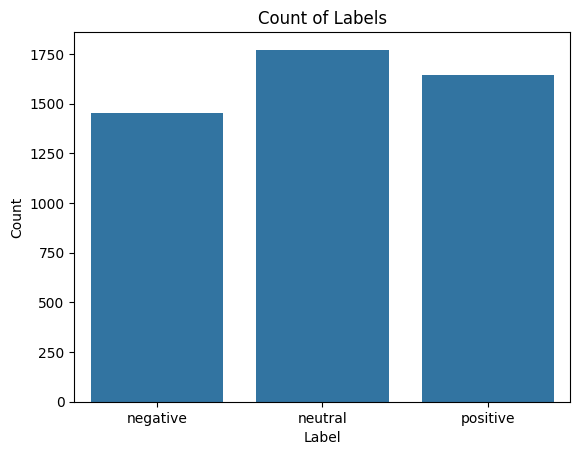

In [ ]:
# Create the bar graph using Seaborn
sns.barplot(
    x='LABEL'
    , y='size'
      , data=df.groupby(
        ['LABEL']
        , as_index=False
    ).size()
)

# Add title and labels
plt.title('Count of Labels')
plt.xlabel('Label')
plt.ylabel('Count')

It's now time to split the dataset in three segments and transform it from a `pandas` dataframe to an `HuggingFace` one to easily interact with the pretrained models:
*   **Training**: the observations from which the model will learn
*   **Validation**: the observation used to evaluate the model while learning
*   **Test**: a final model evaluation aimed at verifying the behaviour on unseen data

In [ ]:
# Training, Validation and Test
train, test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['labels']
)

dataset = HFDataset.from_pandas(train).cast_column("IMAGE", Image()).train_test_split(test_size=0.2)

train_ds = dataset["train"]
val_ds = dataset["test"]
test_ds = HFDataset.from_pandas(test).cast_column("IMAGE", Image())

Unrelated to the dataset but important for the model evaluation is the choice of the metric that the optimization will aim to maximize (or minimize in case of loss) while training the model.

The chosen one is [f1](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html): the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

Since the `compute_metrics` function is already defined in a previous section of the notebook I'm using `partial` to select f1 weighted for the different classes and have the function ready to be mapped in a DataFrame.

In [ ]:
# Define the metric
chosen_metric = "f1"

compute_chosen_metric = partial(
    compute_metrics, metric_name=chosen_metric, average="weighted"
)

## The NLP Model

It's now time to train the first model: the NLP one. This section is dedicated to fine-tune **bert-tiny** via the AutoModelForSequenceClassification model class on the described sentiment analysis problem.

The **bert-tiny** model:

@misc{bhargava2021generalization,
      title={Generalization in NLI: Ways (Not) To Go Beyond Simple Heuristics},
      author={Prajjwal Bhargava and Aleksandr Drozd and Anna Rogers},
      year={2021},
      eprint={2110.01518},
      archivePrefix={arXiv},
      primaryClass={cs.CL}
}

@article{DBLP:journals/corr/abs-1908-08962,
  author    = {Iulia Turc and
               Ming{-}Wei Chang and
               Kenton Lee and
               Kristina Toutanova},
  title     = {Well-Read Students Learn Better: The Impact of Student Initialization
               on Knowledge Distillation},
  journal   = {CoRR},
  volume    = {abs/1908.08962},
  year      = {2019},
  url       = {http://arxiv.org/abs/1908.08962},
  eprinttype = {arXiv},
  eprint    = {1908.08962},
  timestamp = {Thu, 29 Aug 2019 16:32:34 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/abs-1908-08962.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}

In [ ]:
# Load model and tokenizer
text_model_name = "prajjwal1/bert-tiny"
text_tokenizer = AutoTokenizer.from_pretrained(text_model_name)
text_model = AutoModelForSequenceClassification.from_pretrained(
    text_model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Apply the text tokenizer to the training dataset
train_ds_tokenized = train_ds.map(
    lambda x: text_tokenizer(
        x['TEXT'],  # Input text from the 'TEXT' column
        padding="max_length",  # Pad sequences to the maximum length
        truncation=True,  # Truncate sequences exceeding the maximum length
        max_length=128  # Set the maximum sequence length to 128
    ),
    batched=False  # Process each example individually (not in batches)
)

# Apply the text tokenizer to the validation dataset
val_ds_tokenized = val_ds.map(
    lambda x: text_tokenizer(
        x['TEXT'],  # Input text from the 'TEXT' column
        padding="max_length",  # Pad sequences to the maximum length
        truncation=True,  # Truncate sequences exceeding the maximum length
        max_length=128  # Set the maximum sequence length to 128
    ),
    batched=False  # Process each example individually (not in batches)
)

Map:   0%|          | 0/3116 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Map:   0%|          | 0/779 [00:00<?, ? examples/s]

In [ ]:
# Create Hugging Face Dataset for training
train_ds_tokenized = HFDataset.from_dict({
    'input_ids': train_ds_tokenized['input_ids'],  # Token IDs for the input text
    'attention_mask': train_ds_tokenized['attention_mask'],  # Attention mask to indicate valid tokens
    'labels': [int(label) for label in train_ds_tokenized['labels']]  # Sentiment labels as integers
})

# Create Hugging Face Dataset for validation
val_ds_tokenized = HFDataset.from_dict({
    'input_ids': val_ds_tokenized['input_ids'],  # Token IDs for the input text
    'attention_mask': val_ds_tokenized['attention_mask'],  # Attention mask to indicate valid tokens
    'labels': [int(label) for label in val_ds_tokenized['labels']]  # Sentiment labels as integers
})

In [ ]:
# Training arguments
text_training_args = TrainingArguments(
    output_dir="./text_results",
    num_train_epochs=20,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=100,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./text_logs",
    report_to="none",
    remove_unused_columns=False
)

In [ ]:
# Initialize Trainer
text_training = Trainer(
    model=text_model,
    args=text_training_args,
    train_dataset=train_ds_tokenized,
    eval_dataset=val_ds_tokenized,
    compute_metrics=compute_chosen_metric,
)

In [ ]:
# Train the model
text_training.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,1.080413,0.361284
2,No log,1.030889,0.502769
3,No log,0.912260,0.633279
4,No log,0.820155,0.681822
5,No log,0.750319,0.696196
6,0.954500,0.713303,0.699815
7,0.954500,0.688771,0.713844
8,0.954500,0.691817,0.705620
9,0.954500,0.673820,0.720985
10,0.954500,0.669019,0.728318


TrainOutput(global_step=1960, training_loss=0.5670271192278181, metrics={'train_runtime': 71.6794, 'train_samples_per_second': 869.427, 'train_steps_per_second': 27.344, 'total_flos': 19800362250240.0, 'train_loss': 0.5670271192278181, 'epoch': 20.0})

In [ ]:
text_training.evaluate(eval_dataset=val_ds_tokenized)

{'eval_loss': 0.7053284645080566,
 'eval_f1': 0.7218406799021082,
 'eval_runtime': 0.9817,
 'eval_samples_per_second': 793.53,
 'eval_steps_per_second': 13.242,
 'epoch': 20.0}

Once the performance of the model is satisfactory the result I save the trained model in a separate folder in the Colab environment, it's going to be used in a later stage for the multi-modal model

In [ ]:
# Save model and tokenizer
text_model.save_pretrained("./text_classifier")
text_tokenizer.save_pretrained("./text_classifier")

('./text_classifier/tokenizer_config.json',
 './text_classifier/special_tokens_map.json',
 './text_classifier/vocab.txt',
 './text_classifier/added_tokens.json',
 './text_classifier/tokenizer.json')

I'm deleting variables that are no more relevant to this notebook to avoid cluttering the memory of the system.

In [ ]:
del df
del dataset
del dfText
del output_file
del output_folder
del test
del text_model
del text_model_name
del text_tokenizer
del text_training
del train
del text_training_args
del train_ds_tokenized
del val_ds_tokenized
del zip_ref
del url

## The Computer Vision Model

Just like the previous section this one is dedicated to fine-tune **mobilenet_v2_1.0_224** via the MobileNetV2ForImageClassification on the described sentiment analysis problem.

The **mobilenet_v2_1.0_224**  model:

@inproceedings{mobilenetv22018,
  title={MobileNetV2: Inverted Residuals and Linear Bottlenecks},
  author={Mark Sandler and Andrew Howard and Menglong Zhu and Andrey Zhmoginov and Liang-Chieh Chen},
  booktitle={CVPR},
  year={2018}
}


In [ ]:
# Initialize processor and model
img_model_name = "google/mobilenet_v2_1.0_224"
img_processor = MobileNetV2ImageProcessor.from_pretrained(img_model_name)
img_model = MobileNetV2ForImageClassification.from_pretrained(
    img_model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

preprocessor_config.json:   0%|          | 0.00/406 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

Some weights of MobileNetV2ForImageClassification were not initialized from the model checkpoint at google/mobilenet_v2_1.0_224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1001]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1001, 1280]) in the checkpoint and torch.Size([3, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Create copies of the training and validation datasets for image-specific preprocessing
train_ds_img = copy.copy(train_ds)
val_ds_img = copy.copy(val_ds)

# Use partial to create a function that applies the transform with the image processor
img_model_transform = partial(transform, img_processor=img_processor)

# Set the transform function for the training dataset
train_ds_img.set_transform(img_model_transform)
# Set the transform function for the validation dataset
val_ds_img.set_transform(img_model_transform)

In [ ]:
# Training arguments
img_training_args = TrainingArguments(
    output_dir="./img_results",
    remove_unused_columns=False,
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=100,
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./img_logs",
    report_to="none",
    push_to_hub=False
)

In [ ]:
# Initialize Trainer
img_training = Trainer(
    model=img_model,
    args=img_training_args,
    train_dataset=train_ds_img,
    eval_dataset=val_ds_img,
    compute_metrics=compute_chosen_metric
)

In [ ]:
# Train
img_training.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,1.125402,0.346465
2,No log,1.116450,0.347628
3,No log,1.117272,0.384373
4,No log,1.122498,0.403438
5,No log,1.174732,0.378216
6,0.913400,1.211050,0.381135
7,0.913400,1.208184,0.404367
8,0.913400,1.265778,0.389976
9,0.913400,1.232417,0.392034
10,0.913400,1.261312,0.381411


TrainOutput(global_step=980, training_loss=0.6901079606036751, metrics={'train_runtime': 432.4673, 'train_samples_per_second': 72.052, 'train_steps_per_second': 2.266, 'total_flos': 6.26939480788992e+16, 'train_loss': 0.6901079606036751, 'epoch': 10.0})

In [ ]:
img_training.evaluate(eval_dataset=val_ds_img)

{'eval_loss': 1.2613122463226318,
 'eval_f1': 0.3814113051518673,
 'eval_runtime': 7.6764,
 'eval_samples_per_second': 101.479,
 'eval_steps_per_second': 1.693,
 'epoch': 10.0}

Once more also this trained model is saved in a separate folder in the Colab environment: it's going to be used in a later stage for the multi-modal model

In [ ]:
# Save model and processor
img_model.save_pretrained("./img_classifier")
img_processor.save_pretrained("./img_classifier")

['./img_classifier/preprocessor_config.json']

I'm deleting variables that are no more relevant to this notebook to avoid cluttering the memory of the system.

In [ ]:
del img_model
del img_model_name
del img_model_transform
del img_processor
del img_training
del img_training_args
del train_ds_img
del val_ds_img

## The Multimodal Model

Levarging the fine-tuned models I just created for text and images in this section I'm building a final model that extract the embeddings from both the previous models and trains a final Sequential Neural Network on top. To do so I implemented a custom **MultimodalPreprocessor** and also a custom **MultimodalDataset**.

While for the previous fine-tuning tasks I used Huggingface Trainer interface for my custom mdel I'm going to use a pure Pytorch approach (the reason I also need the DataLoader).

I'm going to extract the embeddings, lower-dimensional representations of sparse data, from the text and image models and I'm going to combine them using an attention mechanism. Since I already trained the text and image models I'm freezing their hidden layers and training only the Sequential Classifier that is working on the combined embeddings

The [attention mechanism](https://www.ibm.com/think/topics/attention-mechanism) that connects the two separate embeddings sets prioritize (or attend to) the most relevant parts of input data whether it comes from the text or from the image.

In [ ]:
# Create the preprocessor
preprocessor = MultimodalPreprocessor(text_model_name="./text_classifier", img_model_name="./img_classifier", device=device)

In [ ]:
# Define the dimensions of the text and image embeddings
text_embedding_dim = 128  # Dimension of the text embeddings (output from the text model)
img_embedding_dim = 1280  # Dimension of the image embeddings (output from the image model)

# Define the number of classes for classification and the number of attention heads
num_classes = 3  # Number of sentiment classes (e.g., positive, negative, neutral)
num_heads = 8  # Number of attention heads for the multi-head attention mechanism

# Create an instance of the MultimodalModel
model = MultimodalModel(text_embedding_dim, img_embedding_dim, num_classes, num_heads).to(device)
# Move the model to the specified device (e.g., GPU or CPU)

In [ ]:
# Create PyTorch datasets for training and validation
train_dataset_torch = MultimodalDataset(train_ds, preprocessor)
val_dataset_torch = MultimodalDataset(val_ds, preprocessor)

In [ ]:
# Create DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset_torch, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset_torch, batch_size=64)

In [ ]:
# Training loop
num_epochs = 20  # Number of training epochs
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Initialize the Adam optimizer
criterion = nn.CrossEntropyLoss()  # Define the loss function (Cross-Entropy Loss for multi-class classification)

# Iterate over the specified number of epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Iterate over the training data in batches
    for batch in train_dataloader:
        # Get the text embeddings, image embeddings, and labels from the batch
        text_embeddings = batch["text_embedding"].to(device)  # Move text embeddings to the device (e.g., GPU)
        img_embeddings = batch["img_embedding"].to(device)  # Move image embeddings to the device
        labels = batch["labels"].to(device)  # Move labels to the device

        optimizer.zero_grad()  # Reset the gradients of the optimizer

        # Forward pass: Get model predictions
        outputs = model(text_embeddings, img_embeddings)
        # Calculate the loss
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagate the loss to calculate gradients
        optimizer.step()  # Update model parameters based on the calculated gradients

    # Print the training loss for the current epoch
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    # Validation
    model.eval()  # Set the model to evaluation mode

    all_predictions = []
    all_labels = []

    # Disable gradient calculation during validation
    with torch.no_grad():
        # Iterate over the validation data in batches
        for batch in val_dataloader:
            # Get the text embeddings, image embeddings, and labels from the batch
            text_embeddings = batch["text_embedding"].to(device)  # Move text embeddings to the device
            img_embeddings = batch["img_embedding"].to(device)  # Move image embeddings to the device
            labels = batch["labels"].to(device)  # Move labels to the device

            # Forward pass: Get model predictions
            outputs = model(text_embeddings, img_embeddings)

            # Store predictions and labels for metric calculation
            all_predictions.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate predictions and labels
    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    # Calculate chosen metric
    metrics = compute_chosen_metric((all_predictions, all_labels))

    # Print validation results for the current epoch
    print(f"Epoch {epoch + 1}, Validation Metrics: {metrics}")

Epoch 1, Loss: 0.23315578699111938
Epoch 1, Validation Metrics: {'f1': 0.6887672129279561}
Epoch 2, Loss: 0.32365337014198303
Epoch 2, Validation Metrics: {'f1': 0.7057659709395223}
Epoch 3, Loss: 0.362900972366333
Epoch 3, Validation Metrics: {'f1': 0.6839165485385847}
Epoch 4, Loss: 0.37283602356910706
Epoch 4, Validation Metrics: {'f1': 0.6984547345735006}
Epoch 5, Loss: 0.5351477265357971
Epoch 5, Validation Metrics: {'f1': 0.6921446291106775}
Epoch 6, Loss: 0.10452946275472641
Epoch 6, Validation Metrics: {'f1': 0.6990484855891074}
Epoch 7, Loss: 0.8821008205413818
Epoch 7, Validation Metrics: {'f1': 0.6962316956160935}
Epoch 8, Loss: 0.0810641273856163
Epoch 8, Validation Metrics: {'f1': 0.6890137360298073}
Epoch 9, Loss: 0.1752738505601883
Epoch 9, Validation Metrics: {'f1': 0.6923986970790107}
Epoch 10, Loss: 0.34050118923187256
Epoch 10, Validation Metrics: {'f1': 0.7005898297140714}
Epoch 11, Loss: 0.21931390464305878
Epoch 11, Validation Metrics: {'f1': 0.6953291736566185}
E

In [ ]:
# Save the model
torch.save(model.state_dict(), "multimodal_model.pth")

In [ ]:
# Pickle the Perprocessor and Dataloader:
joblib.dump(MultimodalPreprocessor, 'MultimodalPreprocessor.joblib')
joblib.dump(MultimodalDataset, 'MultimodalDataset.joblib')

['MultimodalDataset.joblib']

The model, the MultimodalProcessor and the MultimodalDataset are available at the following links:
*   [Model](https://drive.google.com/file/d/1Xbjrxt71I1dtxK52dt3HJRpgxvYDVxEo/view?usp=drive_link)
*   [MultimodalProcessor](https://drive.google.com/file/d/1lXT6fkphn7rE_iK-0FigDOAIWDK6d8Dz/view?usp=drive_link)
*   [MultimodalDataset](https://drive.google.com/file/d/1MoUxIf_wLKGy_js_Zarzsz7tcEI5XZsM/view?usp=drive_link)

## Evaluation of the results

The model is now ready, I evaluate its performance on both the validation and the test set that was separated from the dataset before training the models.

In [ ]:
# Validation
model.eval()  # Set the model to evaluation mode

all_predictions = []
all_labels = []

# Disable gradient calculation during validation
with torch.no_grad():
    # Iterate over the validation data in batches
    for batch in val_dataloader:
        # Get the text embeddings, image embeddings, and labels from the batch
        text_embeddings = batch["text_embedding"].to(device)  # Move text embeddings to the device
        img_embeddings = batch["img_embedding"].to(device)  # Move image embeddings to the device
        labels = batch["labels"].to(device)  # Move labels to the device

        # Forward pass: Get model predictions
        outputs = model(text_embeddings, img_embeddings)

        # Store predictions and labels for metric calculation
        all_predictions.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate predictions and labels
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)

# Calculate chosen metric
metrics = compute_chosen_metric((all_predictions, all_labels))

# Print validation results for the current epoch
print(f"Epoch {epoch + 1}, Validation Metrics: {metrics}")

Epoch 20, Validation Metrics: {'f1': 0.701019000328706}


In [ ]:
# Test Evaluation
test_dataset_torch = MultimodalDataset(test_ds, preprocessor)  # Create a dataset for testing using the test data
test_dataloader = DataLoader(test_dataset_torch, batch_size=64)  # Create a dataloader for batch processing

# Validation
model.eval()  # Set the model to evaluation mode

all_predictions = []
all_labels = []

# Disable gradient calculation during validation
with torch.no_grad():
    # Iterate over the validation data in batches
    for batch in test_dataloader:
        # Get the text embeddings, image embeddings, and labels from the batch
        text_embeddings = batch["text_embedding"].to(device)  # Move text embeddings to the device
        img_embeddings = batch["img_embedding"].to(device)  # Move image embeddings to the device
        labels = batch["labels"].to(device)  # Move labels to the device

        # Forward pass: Get model predictions
        outputs = model(text_embeddings, img_embeddings)

        # Store predictions and labels for metric calculation
        all_predictions.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate predictions and labels
all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)

# Calculate chosen metric
metrics = compute_chosen_metric((all_predictions, all_labels))

# Print validation results for the current epoch
print(f"Epoch {epoch + 1}, Validation Metrics: {metrics}")

Epoch 20, Validation Metrics: {'f1': 0.717817298350808}


In [ ]:
# Convert the labels back to the original sentiment classes
labelled_predictions = [
  id2label[id]
    for id in all_predictions.argmax(axis=1).tolist()
]

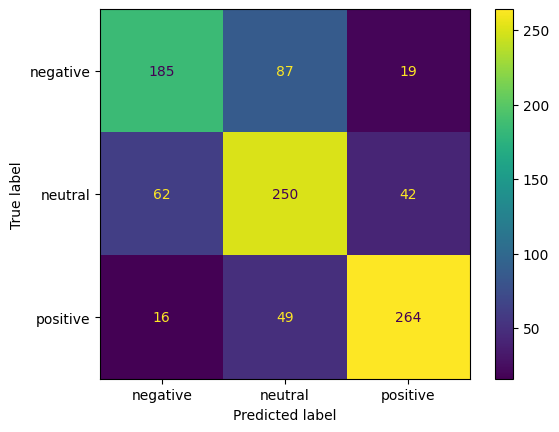

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_true=test_ds['LABEL'], y_pred=labelled_predictions)

In [ ]:
print(
    f"Classification Report:\
    \n{classification_report(y_true=test_ds['LABEL'], y_pred=labelled_predictions)}"
)


Classification Report:    
              precision    recall  f1-score   support

    negative       0.70      0.64      0.67       291
     neutral       0.65      0.71      0.68       354
    positive       0.81      0.80      0.81       329

    accuracy                           0.72       974
   macro avg       0.72      0.71      0.72       974
weighted avg       0.72      0.72      0.72       974



## Conclusion

The Confusion Matrix and the Classification Report indicate that the model demonstrates a balanced performance across the three classes: negative, neutral, and positive.

- **Precision**: The model shows the highest precision for the positive class (0.81), indicating that when it predicts a positive instance, it is correct 81% of the time. The precision for the negative and neutral classes is lower (0.70 and 0.65, respectively), suggesting that there may be some misclassifications in these categories.

- **Recall**: The recall values indicate how well the model identifies instances of each class. The neutral class has the highest recall (0.71), meaning it successfully identifies 71% of the actual neutral instances. The negative class has a lower recall (0.64), which suggests that some negative instances are being misclassified as neutral.

- **F1-Score**: The F1-score, which balances precision and recall, is highest for the positive class (0.81), reflecting a strong performance in identifying positive instances. The scores for the negative and neutral classes are slightly lower (0.67 and 0.68, respectively), indicating room for improvement in these areas.

- **Overall Accuracy**: The model achieves an overall accuracy of 72%, which is reasonable but suggests that there is still potential for enhancement, particularly in the negative and neutral classes.

- **Macro and Weighted Averages**: The macro average scores (precision: 0.72, recall: 0.71, F1-score: 0.72) indicate that the model performs consistently across classes, while the weighted averages reflect the model's performance considering the class distribution, which is also around 0.72.

In summary, while the model performs reasonably well, particularly in identifying positive instances, there is potential for improvement in the negative and neutral classes.